--- Начало обработки файлов: bildstein_station1_xyz_intensity_rgb.txt и bildstein_station1_xyz_intensity_rgb.labels ---
Загрузка облака точек (это может занять время)...
Загрузка меток...
Загружено точек: 29697591
Размерность итогового датасета: (29697591, 8)
Тип данных: float64
--- Сохранение данных ---
Сохранено: semantic3d_dataset.npy
Сохранено: semantic3d_dataset.h5
Сохранено: semantic3d_dataset.txt (Внимание: сохранена только первая 1000 точек для скорости)
--- Визуализация распределения меток ---


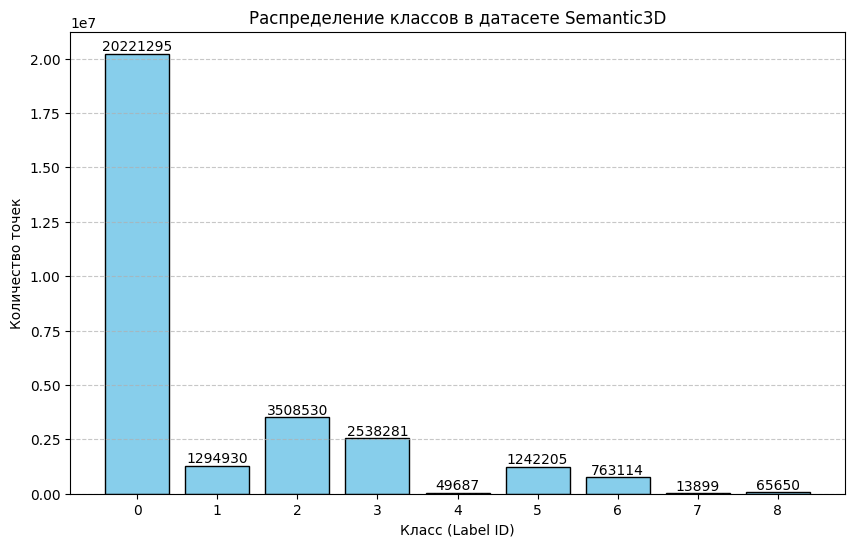


--- Первые 5 строк итогового массива ---
Формат: X  Y  Z  R  G  B  Int  Label
[[ 0.142  0.285 -0.011  0.498  0.553  0.604  0.193  0.   ]
 [ 0.141  0.285 -0.013  0.51   0.553  0.624  0.217  0.   ]
 [ 0.14   0.285 -0.014  0.545  0.592  0.647  0.179  6.   ]
 [ 0.141  0.285 -0.014  0.514  0.576  0.639  0.169  0.   ]
 [ 0.141  0.285 -0.014  0.518  0.569  0.631  0.158  0.   ]]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

def process_semantic3d_data(txt_path, label_path, output_name='semantic3d_dataset'):
    print(f"--- Начало обработки файлов: {txt_path} и {label_path} ---")

    try:
        print("Загрузка облака точек (это может занять время)...")
        data = np.loadtxt(txt_path, dtype=np.float32)

        print("Загрузка меток...")
        labels = np.loadtxt(label_path, dtype=np.int32)
    except OSError as e:
        print(f"Ошибка: Файл не найден. Проверьте путь. {e}")
        return None


    if len(data) != len(labels):
        print(f"Ошибка! Количество точек ({len(data)}) не совпадает с количеством меток ({len(labels)}).")
        return None

    print(f"Загружено точек: {len(data)}")


    X = data[:, 0]
    Y = data[:, 1]
    Z = data[:, 2]
    Intensity = data[:, 3]
    R = data[:, 4]
    G = data[:, 5]
    B = data[:, 6]

    R_norm = R / 255.0
    G_norm = G / 255.0
    B_norm = B / 255.0

    X_norm = X - np.mean(X)
    Y_norm = Y - np.mean(Y)
    Z_norm = Z - np.mean(Z)

    max_coord = np.max(np.abs([X_norm, Y_norm, Z_norm]))
    X_norm = X_norm / max_coord
    Y_norm = Y_norm / max_coord
    Z_norm = Z_norm / max_coord

    if np.max(Intensity) != np.min(Intensity):
         Intensity_norm = (Intensity - np.min(Intensity)) / (np.max(Intensity) - np.min(Intensity))
    else:
         Intensity_norm = Intensity


    dataset = np.column_stack((
        X_norm, Y_norm, Z_norm,
        R_norm, G_norm, B_norm,
        Intensity_norm,
        labels
    ))

    print(f"Размерность итогового датасета: {dataset.shape}")
    print(f"Тип данных: {dataset.dtype}")


    print("--- Сохранение данных ---")


    np.save(f'{output_name}.npy', dataset)
    print(f"Сохранено: {output_name}.npy")


    with h5py.File(f'{output_name}.h5', 'w') as f:
        f.create_dataset('dataset', data=dataset)
    print(f"Сохранено: {output_name}.h5")

    np.savetxt(f'{output_name}.txt', dataset[:1000], fmt='%.4f')
    print(f"Сохранено: {output_name}.txt (Внимание: сохранена только первая 1000 точек для скорости)")

    return dataset


def plot_label_distribution(dataset):
    print("--- Визуализация распределения меток ---")

    labels = dataset[:, 7]


    unique_labels, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(unique_labels, counts, color='skyblue', edgecolor='black')

    plt.xlabel('Класс (Label ID)')
    plt.ylabel('Количество точек')
    plt.title('Распределение классов в датасете Semantic3D')
    plt.xticks(unique_labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    plt.show()


txt_filename = 'bildstein_station1_xyz_intensity_rgb.txt'
label_filename = 'bildstein_station1_xyz_intensity_rgb.labels'


if not os.path.exists(txt_filename):
    print("Файлы не найдены! Создаю тестовые файлы для демонстрации...")

    dummy_data = np.random.rand(100, 7) * 100
    dummy_data[:, 4:7] = dummy_data[:, 4:7] * 2.55
    np.savetxt(txt_filename, dummy_data, fmt='%.3f')

    dummy_labels = np.random.randint(0, 8, 100)
    np.savetxt(label_filename, dummy_labels, fmt='%d')
    print("Тестовые файлы созданы. Теперь запускаем основной алгоритм.")


final_dataset = process_semantic3d_data(txt_filename, label_filename)

if final_dataset is not None:

    plot_label_distribution(final_dataset)

    print("\n--- Первые 5 строк итогового массива ---")
    print("Формат: X  Y  Z  R  G  B  Int  Label")

    np.set_printoptions(precision=3, suppress=True)
    print(final_dataset[:5])